In [60]:
# pip -q install wordcloud

In [61]:
# pip install --upgrade scikit-learn xgboost scikit-optimize

In [ ]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
file = "merged_csv.csv"
df = pd.read_csv(file)
print(df.sample(5))

## EDA

In [ ]:
# 1. Data Loading and Inspection
print("DATA INFO")
df.info()
print("="*50)

print("MISSING VALUES")
print(df.isnull().sum())
print("="*50)

print("BASIC STATISTICS")
print(df.describe())

In [ ]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract time features
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['day_name'] = df['date'].dt.day_name()

print(df[['date', 'hour', 'day_of_week', 'day_name']].head())

LABEL DISTRIBUTION
label
1    28457
0    21403
Name: count, dtype: int64


Percentage:
label
1    57.073807
0    42.926193
Name: proportion, dtype: float64


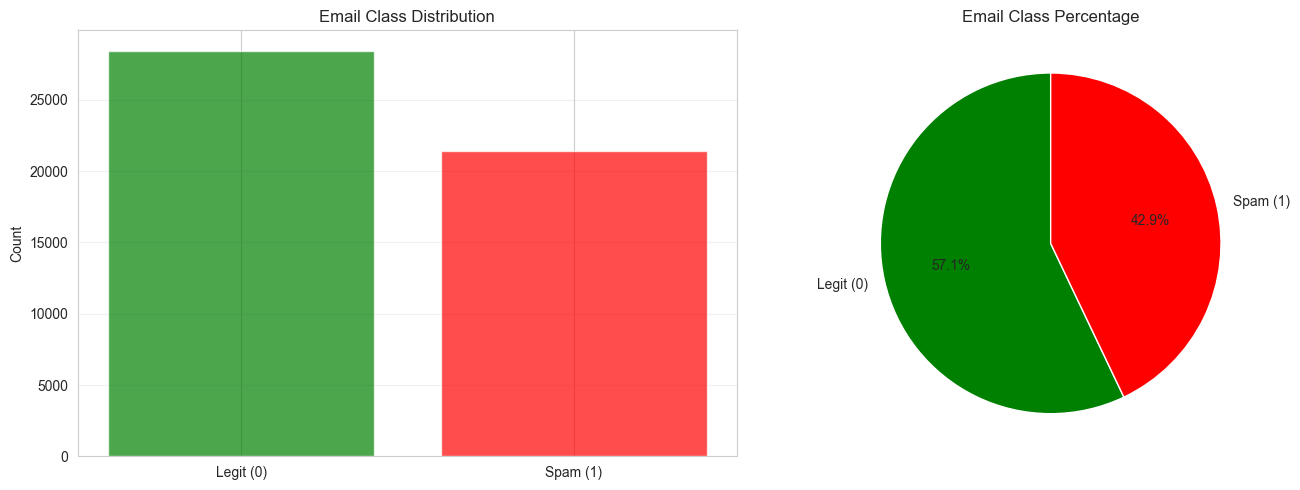

In [66]:
# 2. Target Variable Analysis
print("="*50)
print("LABEL DISTRIBUTION")
print("="*50)
label_counts = df['label'].value_counts()
print(label_counts)
print("\n")

label_pct = df['label'].value_counts(normalize=True) * 100
print("Percentage:")
print(label_pct)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
axes[0].bar(['Legit (0)', 'Spam (1)'], label_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_ylabel('Count')
axes[0].set_title('Email Class Distribution')
axes[0].grid(axis='y', alpha=0.3)

# Percentage plot
axes[1].pie(label_counts.values, labels=['Legit (0)', 'Spam (1)'], autopct='%1.1f%%', 
            colors=['green', 'red'], startangle=90)
axes[1].set_title('Email Class Percentage')

plt.tight_layout()
plt.show()

In [67]:
# 3. Text Feature Analysis - Length Analysis
# Calculate text lengths
df['subject_length'] = df['subject'].fillna('').astype(str).apply(len)
df['body_length'] = df['body'].fillna('').astype(str).apply(len)
df['subject_word_count'] = df['subject'].fillna('').astype(str).apply(lambda x: len(x.split()))
df['body_word_count'] = df['body'].fillna('').astype(str).apply(lambda x: len(x.split()))

# Compare by label
length_comparison = df.groupby('label')[['subject_length', 'body_length', 
                                          'subject_word_count', 'body_word_count']].agg(['mean', 'median', 'std'])
length_comparison

subject_length                    body_length                        \
                mean median        std         mean  median           std   
label                                                                       
0          45.882259   43.0  20.853937  2446.218614  1196.0   5485.953477   
1          31.489159   27.0  23.896735  1382.807253   344.0  28077.642505   

      subject_word_count                  body_word_count                     
                    mean median       std            mean median         std  
label                                                                         
0               6.842779    6.0  3.101618      337.557679  179.0  675.277252  
1               5.037530    5.0  4.049082      152.650701   55.0  849.972934

In [68]:
# 4. Word Frequency Analysis
# Prepare text data
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)

# Get English stopwords
stop_words = set(stopwords.words('english'))
# Add custom stopwords specific to emails
stop_words.update(['re', 'fwd', 'subject'])

def get_top_words(text_series, top_n=15):
    """Extract top N words from text series"""
    all_words = []
    for text in text_series:
        if pd.notna(text):
            # Convert to lowercase and extract words
            words = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
            # Filter out stopwords
            words = [w for w in words if w not in stop_words]
            all_words.extend(words)
    
    # Count and return top N
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# Get top words for Legit and Spam
legit_subject_words = get_top_words(df[df['label']==0]['subject'])
spam_subject_words = get_top_words(df[df['label']==1]['subject'])
legit_body_words = get_top_words(df[df['label']==0]['body'])
spam_body_words = get_top_words(df[df['label']==1]['body'])

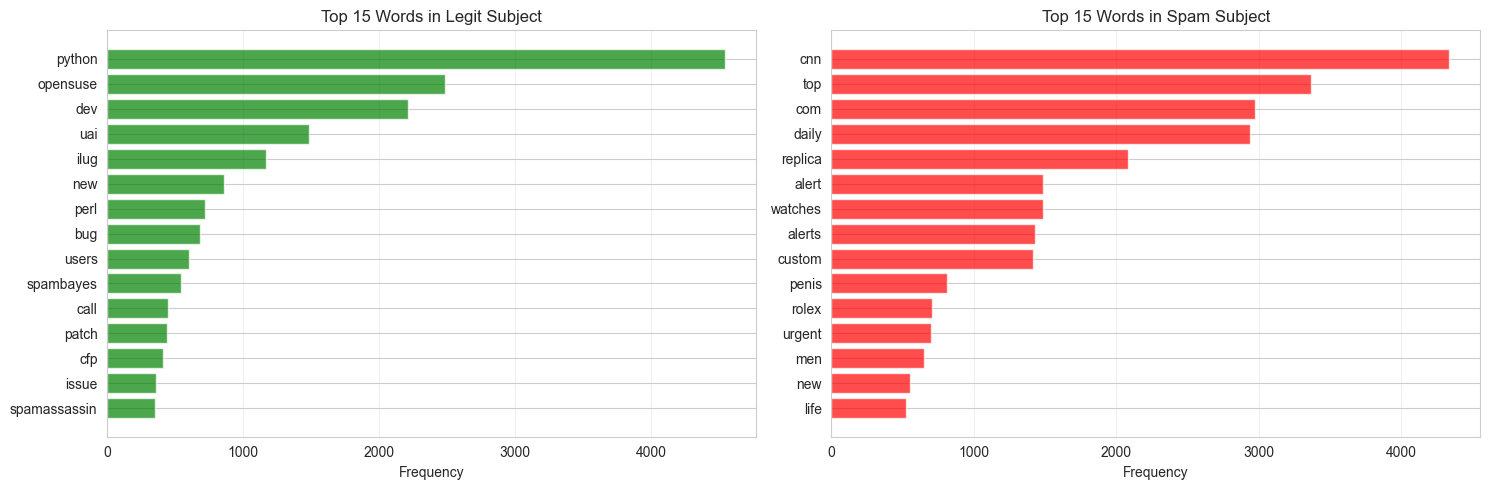

In [69]:
# Plot - Subject Words
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Legit subject words
words, counts = zip(*legit_subject_words)
axes[0].barh(range(len(words)), counts, color='green', alpha=0.7)
axes[0].set_yticks(range(len(words)))
axes[0].set_yticklabels(words)
axes[0].invert_yaxis()
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 15 Words in Legit Subject')
axes[0].grid(axis='x', alpha=0.3)

# Spam subject words
words, counts = zip(*spam_subject_words)
axes[1].barh(range(len(words)), counts, color='red', alpha=0.7)
axes[1].set_yticks(range(len(words)))
axes[1].set_yticklabels(words)
axes[1].invert_yaxis()
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 15 Words in Spam Subject')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

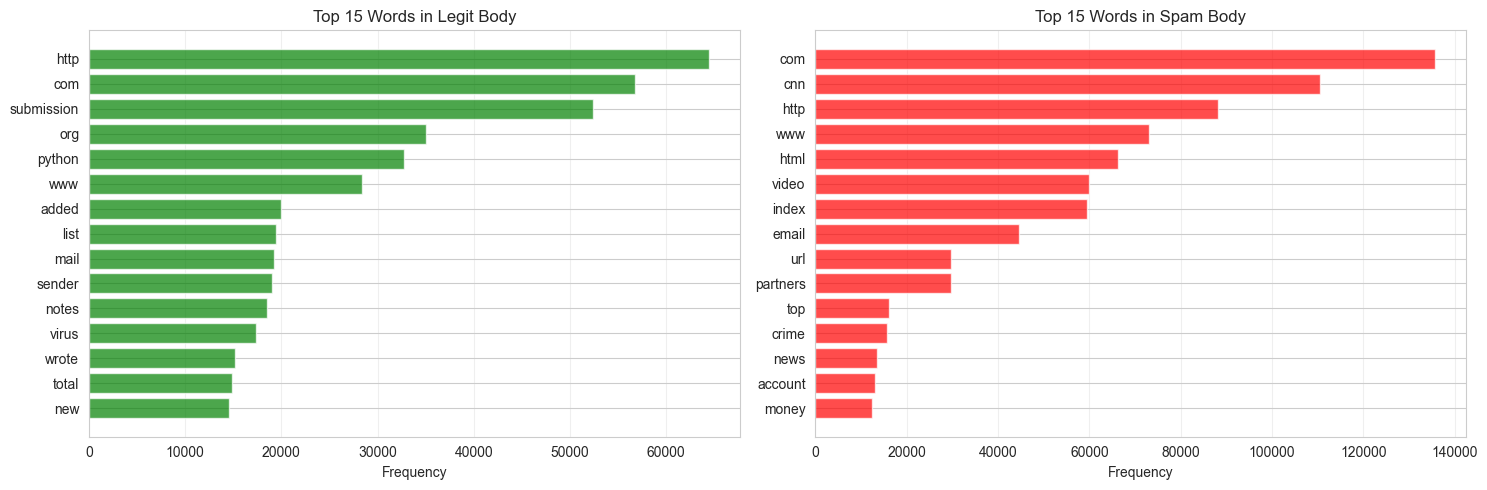

In [70]:
# Plot - Body Words
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Legit body words
words, counts = zip(*legit_body_words)
axes[0].barh(range(len(words)), counts, color='green', alpha=0.7)
axes[0].set_yticks(range(len(words)))
axes[0].set_yticklabels(words)
axes[0].invert_yaxis()
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 15 Words in Legit Body')
axes[0].grid(axis='x', alpha=0.3)

# Spam body words
words, counts = zip(*spam_body_words)
axes[1].barh(range(len(words)), counts, color='red', alpha=0.7)
axes[1].set_yticks(range(len(words)))
axes[1].set_yticklabels(words)
axes[1].invert_yaxis()
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 15 Words in Spam Body')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

URL ANALYSIS BY LABEL
           mean  median       std  min  max
label                                      
0      0.698453     1.0  0.458940    0    1
1      0.662649     1.0  0.472814    0    1




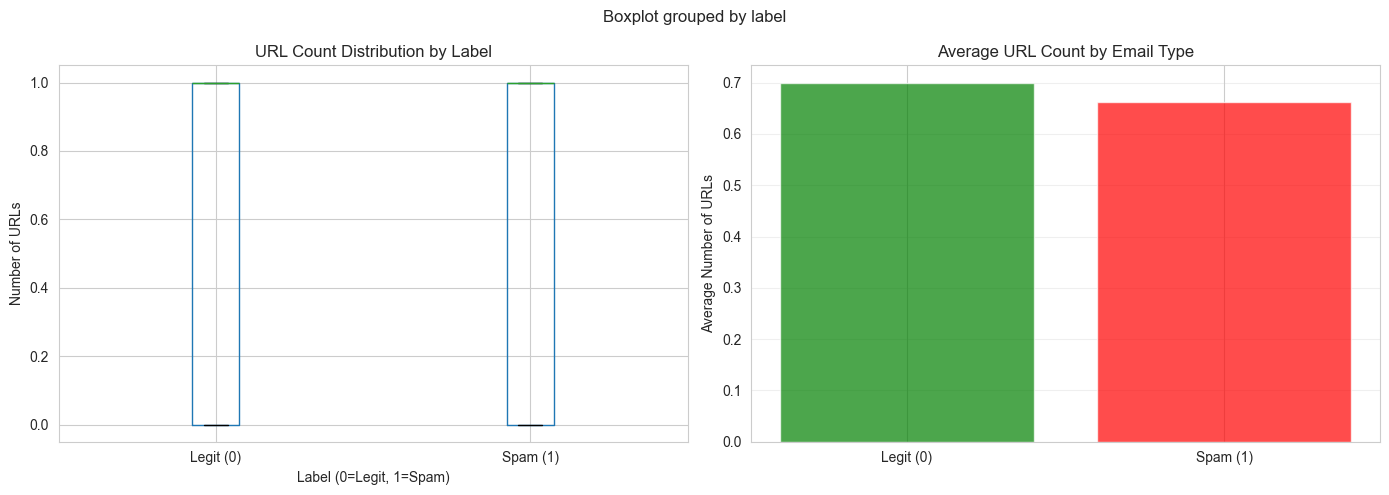

In [71]:
# 5. Metadata Analysis - URLs
print("="*50)
print("URL ANALYSIS BY LABEL")
print("="*50)
url_stats = df.groupby('label')['urls'].agg(['mean', 'median', 'std', 'min', 'max'])
print(url_stats)
print("\n")


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
df.boxplot(column='urls', by='label', ax=axes[0])
axes[0].set_xlabel('Label (0=Legit, 1=Spam)')
axes[0].set_ylabel('Number of URLs')
axes[0].set_title('URL Count Distribution by Label')
plt.sca(axes[0])
plt.xticks([1, 2], ['Legit (0)', 'Spam (1)'])

# Bar plot of means
axes[1].bar(['Legit (0)', 'Spam (1)'], url_stats['mean'].values, color=['green', 'red'], alpha=0.7)
axes[1].set_ylabel('Average Number of URLs')
axes[1].set_title('Average URL Count by Email Type')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [72]:
# 6. Sender Domain Analysis
# Extract domain from sender
df['sender_domain'] = df['sender'].fillna('').astype(str).apply(lambda x: x.split('@')[-1] if '@' in x else 'unknown')

print("="*50)
print("TOP 10 SENDER DOMAINS - HAM")
print("="*50)
print(df[df['label']==0]['sender_domain'].value_counts().head(10))
print("\n")

print("="*50)
print("TOP 10 SENDER DOMAINS - SPAM")
print("="*50)
print(df[df['label']==1]['sender_domain'].value_counts().head(10))

TOP 10 SENDER DOMAINS - HAM
sender_domain
gmail.com>                 2610
spamassassin.taint.org>     602
python.org>                 523
issues.apache.org           462
v.loewis.de>                289
perl.org>                   209
telefonica.net>             208
hotmail.com>                206
lists.techtarget.com>       201
massey.ac.nz                183
Name: count, dtype: int64


TOP 10 SENDER DOMAINS - SPAM
sender_domain
unknown          1318
hotmail.com>      431
yahoo.com>        400
google.com>       209
virgilio.it>      152
yahoo.co.uk>      119
hotmail.fr>       107
msn.com>           91
netscape.net>      91
hotmail.com        85
Name: count, dtype: int64


In [73]:
# 7. Time-based Analysis
print("="*50)
print("EMAIL SENDING TIME ANALYSIS")
print("="*50)

# Hour analysis
hour_stats = df.groupby(['label', 'hour']).size().unstack(fill_value=0)
print("\nEmails by Hour:")
pd.set_option('display.max_columns', None)
hour_stats



EMAIL SENDING TIME ANALYSIS

Emails by Hour:


hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
label,,,,,,,,,,,,,,,,,,,,,,,,
0,160,152,230,124,142,97,125,98,606,88,109,111,135,131,53,150,58,42,60,71,67,67,65,97
1,154,267,220,264,249,194,113,110,183,202,236,242,216,145,180,194,160,181,191,168,169,136,153,211


In [74]:
# Day of week analysis
day_stats = df.groupby(['label', 'day_name']).size().unstack(fill_value=0)
print("Emails by Day of Week:")
print(day_stats)

Emails by Day of Week:
day_name  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
label                                                                   
0            835     109        41      44       865      230        914
1            455     205       127     100      1365      357       1929


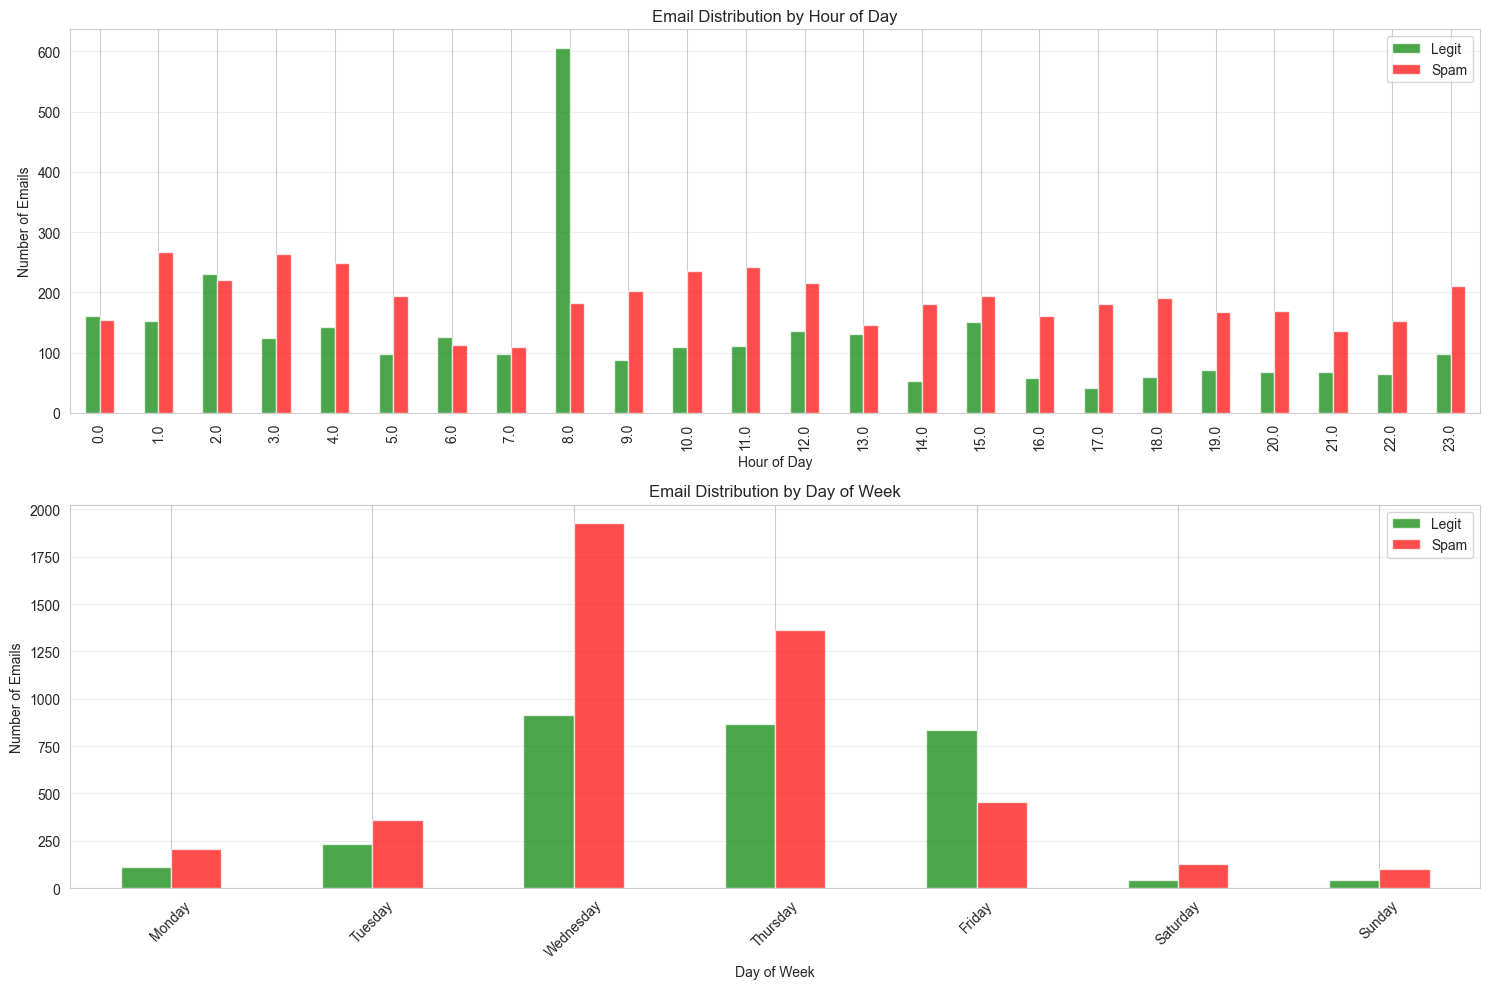

In [75]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Hour distribution
hour_df = df.groupby(['hour', 'label']).size().unstack(fill_value=0)
hour_df.plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Emails')
axes[0].set_title('Email Distribution by Hour of Day')
axes[0].legend(['Legit', 'Spam'])
axes[0].grid(axis='y', alpha=0.3)

# Day of week distribution
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = df.groupby(['day_name', 'label']).size().unstack(fill_value=0)
day_df = day_df.reindex(day_order)
day_df.plot(kind='bar', ax=axes[1], color=['green', 'red'], alpha=0.7)
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Emails')
axes[1].set_title('Email Distribution by Day of Week')
axes[1].legend(['Legit', 'Spam'])
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(day_order, rotation=45)

plt.tight_layout()
plt.show()

In [76]:
# Summary Report
print("="*70)
print("EXPLORATORY DATA ANALYSIS SUMMARY")
print("="*70)
print(f"Total emails: {len(df)}")
print(f"Legit emails: {len(df[df['label']==0])} ({len(df[df['label']==0])/len(df)*100:.1f}%)")
print(f"Spam emails: {len(df[df['label']==1])} ({len(df[df['label']==1])/len(df)*100:.1f}%)")
print(f"\nAverage URLs in Legit: {df[df['label']==0]['urls'].mean():.2f}")
print(f"Average URLs in Spam: {df[df['label']==1]['urls'].mean():.2f}")
print(f"\nAverage subject length - Legit: {df[df['label']==0]['subject_length'].mean():.0f} chars")
print(f"Average subject length - Spam: {df[df['label']==1]['subject_length'].mean():.0f} chars")
print(f"\nAverage body length - Legit: {df[df['label']==0]['body_length'].mean():.0f} chars")
print(f"Average body length - Spam: {df[df['label']==1]['body_length'].mean():.0f} chars")
print("="*70)

EXPLORATORY DATA ANALYSIS SUMMARY
Total emails: 49860
Legit emails: 21403 (42.9%)
Spam emails: 28457 (57.1%)

Average URLs in Legit: 0.70
Average URLs in Spam: 0.66

Average subject length - Legit: 46 chars
Average subject length - Spam: 31 chars

Average body length - Legit: 2446 chars
Average body length - Spam: 1383 chars


In [77]:
# 8. Advanced Text Feature Analysis
import string

# Apply feature engineering
def calculate_capital_ratio(text):
    """Calculate ratio of uppercase letters"""
    if pd.isna(text) or len(str(text)) == 0:
        return 0
    text = str(text)
    uppercase_count = sum(1 for c in text if c.isupper())
    letter_count = sum(1 for c in text if c.isalpha())
    return uppercase_count / letter_count if letter_count > 0 else 0

df['subject_capital_ratio'] = df['subject'].apply(calculate_capital_ratio)
df['body_capital_ratio'] = df['body'].apply(calculate_capital_ratio)



In [78]:
def count_special_punctuation(text):
    """Count special punctuation like !, $, ?, etc."""
    if pd.isna(text):
        return 0
    special_chars = ['!', '$', '?', '*', '%']
    return sum(str(text).count(char) for char in special_chars)

df['subject_special_punct'] = df['subject'].apply(count_special_punctuation)
df['body_special_punct'] = df['body'].apply(count_special_punctuation)



In [79]:
from nltk.sentiment import SentimentIntensityAnalyzer
# VADER lexicon for sentiment analysis
nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

In [80]:
def get_sentiment_score(text):
    """Get compound sentiment score using VADER
        Positive values (closer to 1): indicate positive sentiment (happy, excited, optimistic).
        Negative values (closer to -1): indicate negative sentiment (angry, sad, pessimistic).
        Values near 0: indicate neutral sentiment.
    """
    if pd.isna(text):
        return 0
    return sia.polarity_scores(str(text))['compound']

df['subject_sentiment'] = df['subject'].apply(get_sentiment_score)
df['body_sentiment'] = df['body'].apply(get_sentiment_score)


In [81]:
# Compare features by label
print("="*70)
print("ADVANCED TEXT FEATURES COMPARISON")
print("="*70)

feature_comparison = df.groupby('label')[['subject_capital_ratio', 'body_capital_ratio',
                                           'subject_special_punct', 'body_special_punct',
                                           'subject_sentiment', 'body_sentiment']].agg(['mean', 'median', 'std'])
feature_comparison

ADVANCED TEXT FEATURES COMPARISON


subject_capital_ratio                     body_capital_ratio            \
                       mean    median       std               mean    median   
label                                                                          
0                  0.165121  0.130435  0.143521           0.071461  0.057082   
1                  0.218562  0.129032  0.263737           0.109069  0.055172   

                subject_special_punct                  body_special_punct  \
            std                  mean median       std               mean   
label                                                                       
0      0.052835              0.174228    0.0  0.448200          12.530019   
1      0.141502              0.249886    0.0  1.187806           4.971887   

                        subject_sentiment                  body_sentiment  \
      median        std              mean median       std           mean   
label                                                                       
0        2.0  54.392248         -0.009256    0.0  0.244474       0.405286   
1        1.0  22.905572          0.163584    0.0  0.272865       0.456478   

                         
       median       std  
label                    
0      0.7181  0.654544  
1      0.7184  0.607526

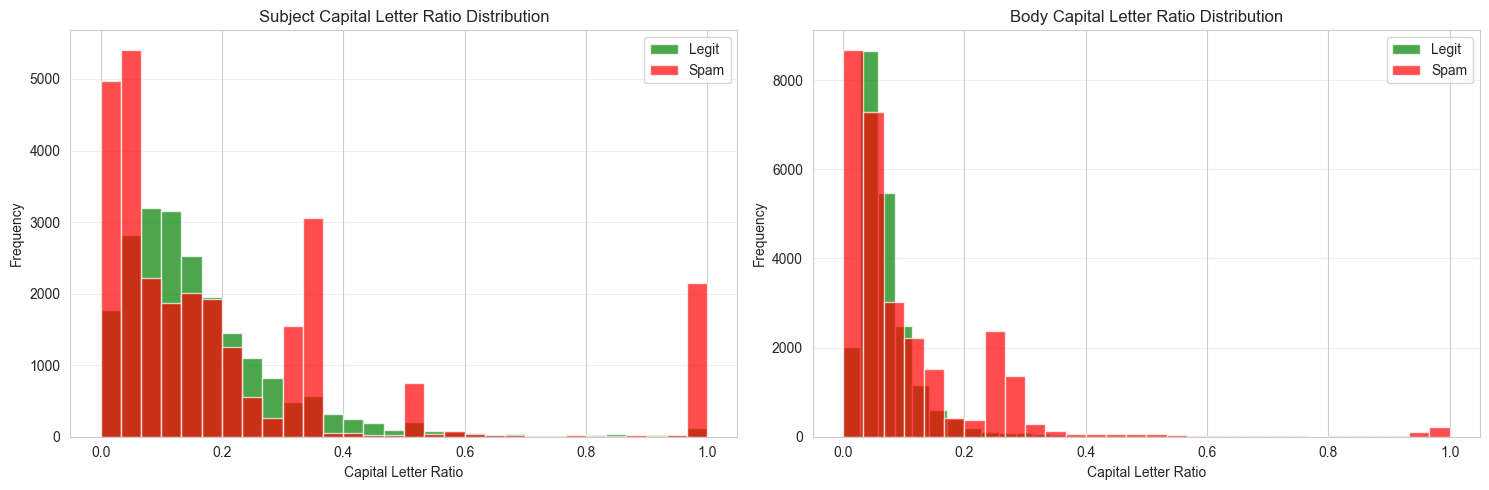

In [82]:
# Visualization - Capital Letter Ratio
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Subject capital ratio
axes[0].hist(df[df['label']==0]['subject_capital_ratio'], bins=30, alpha=0.7, label='Legit', color='green')
axes[0].hist(df[df['label']==1]['subject_capital_ratio'], bins=30, alpha=0.7, label='Spam', color='red')
axes[0].set_xlabel('Capital Letter Ratio')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Subject Capital Letter Ratio Distribution')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Body capital ratio
axes[1].hist(df[df['label']==0]['body_capital_ratio'], bins=30, alpha=0.7, label='Legit', color='green')
axes[1].hist(df[df['label']==1]['body_capital_ratio'], bins=30, alpha=0.7, label='Spam', color='red')
axes[1].set_xlabel('Capital Letter Ratio')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Body Capital Letter Ratio Distribution')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()